# Mini Project 3

Mini Project 3 will have two parts:
1. The first part involves Automated Prompt Engineering where you get to build the use of a Calculator Tool automatically for "Math questions" asked of an LLM. You can compare the evaluation performance with/without the use of the tool and see how it can improve the performance of GPT 3.5.
2. The second part involves the use of Stability AI APIs to work on different image editing tasks - Including "Removing the photobomber" or "Removing artifacts from an image"


### `Deliverables`
Python Notebook: Submit a Python notebook (.ipynb) containing all the code used for the tasks. The notebook should be well-organized, with each task clearly identified and separated.

### `Note`:
Include comments in your code to explain what each section does. This will not only help the graders understand your code, but also help you understand your own code when you look back at it in the future.



# Part 1: Toolformer

### This assignment aims to assess the mathematical reasoning capabilities of Large Language Models (LLMs), specifically focusing on zero-shot learning, few-shot in-context learning, and their ability to integrate external tools when solving arithmetic word problems from the SVAMP dataset. The SVAMP dataset comprises simple variations of arithmetic math word problems up to grade 4, designed to test the models beyond mere pattern recognition and evaluate their genuine problem-solving skills.

In [ ]:
import openai
from datasets import load_dataset

/gscratch/ark/chiahlee/miniconda/envs/DST-prompt3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### The SVAMP dataset (Simple Variations on Arithmetic Math word Problems) represents a specialized challenge set designed to assess the capabilities of state-of-the-art (SOTA) models in solving arithmetic word problems of up to grade 4 level.
#### Unlike conventional benchmarks, which models often solve by exploiting simple heuristics, SVAMP introduces a series of one-unknown math word problems crafted to underscore the limitations of these models, demonstrating their struggle to solve even elementary problems effectively.
#### The challenge is two fold: (1) identify what numbers in the context are actually used for the question and construct a math equation (2) correctly compute the math equation


In [ ]:
dataset = load_dataset("ChilleD/SVAMP")
train_dataset = dataset['train']
test_dataset = dataset['test']
# https://huggingface.co/datasets/ChilleD/SVAMP?row=0


Found cached dataset json (/mmfs1/gscratch/ark/chiahlee/hf_cache/ChilleD___json/ChilleD--SVAMP-4bd8179a65d5f05b/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|██████████| 2/2 [00:00<00:00, 889.19it/s]


In [ ]:
"""ChatGPT completion"""
def chatgpt_completion(prompt_text):
    openai.api_key = "" ######################### Put your API key here  #########################
    return  openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt_text}],
        max_tokens=200,
        temperature=0,
        # stop=['--', '\n', ';', '#'],
        )['choices'][0]['message']['content']


def evaluate(results, answers):
    accs = []
    for result, answer in zip(results, answers):
        try:
            _ = float(result)
            if float(result) == float(answer):
                accs.append(1)
            else:
                accs.append(0)
        except:
            accs.append(0)

    print("The scores on the test set: ", sum(accs)/len(accs)) # around 38% - 50%
    return

## 1. Zero Shot Prompting LLM (i.e. ChatGPT)
#### In this part, we are going to ask ChatGPT to directly answer the math questions without using any tools

In [ ]:
def parse_zeroshot_chatgpt_output(chatgpt_output):
    # Follow Toolformer
    # https://arxiv.org/abs/2302.04761
    # Zero-Shot Math Reasoning with ChatGPT
    # Check for the first number predicted by the model.
    # An exception to this is if the model’s prediction contains an equation (e.g., “The correct answer is 5+3=8”), in which case we consider the first number after the “=” sign to be its prediction.
    def is_number(s):
        try:
            float(s)
            return True
        except ValueError:
            return False
    if "=" in chatgpt_output:
        chatgpt_output = chatgpt_output.split("=")[1]

    words = chatgpt_output.split()
    for word in words:
        if is_number(word):
            return word
    return float("inf")  # Return inf if no number word is found

def zero_shot_prompt_chatgpt(test_dataset):
    results = []
    answers = []
    for data in test_dataset:
        context = data["Body"]
        question = data["Question"]
        answer = data["Answer"]
        answers.append(answer)

        example_prompt =  context + " " + question
        chatgpt_output = chatgpt_completion(example_prompt)
        result = parse_zeroshot_chatgpt_output(chatgpt_output)
        results.append(result)
    return results, answers


In [ ]:
zeroshot_results, answers = zero_shot_prompt_chatgpt(test_dataset)
evaluate(zeroshot_results, answers)  # This should give you scores 38-50%

## 2. Instrution following and tool use with LLM  (i.e. ChatGPT) (40 pts)
#### You will see that zero shot chatgpt performance is less than ideal. Next we are gonna leverage the tool use capabilities of LLM.
#### In this case here, it's the abilitiy to leverage external calculator to deal with math questions.
#### Using Toolformer as a reference, we construct a instruction prompt and also put in a few {input:output} demonstrations to guide ChatGPT to generate the output format we want.
#### You will also be asked to implement some functions to finish the pipeline

In [ ]:
TOOLFORMER_CALCULATOR_PROMPT_4Shot = """
# Your task is to add calls to a
# Calculator API to a piece of text.
# The calls should help you get
# information required to complete the
# text. You can call the API by writing
# "[Calculator(expression)]" where
# "expression" is the expression to be
# computed. Here are some examples of API
# calls:
# Input: The number in the next term is 18
# + 12 x 3 = 54.
# Output: The number in the next term is
# 18 + 12 x 3 = [Calculator(18 + 12 * 3)]
# 54.
# Input: The population is 658,893 people.
# This is 11.4% of the national average of
# 5,763,868 people.
# Output: The population is 658,893 people.
# This is 11.4% of the national average of
# [Calculator(658,893 / 11.4%)] 5,763,868
# people.
# Input: A total of 252 qualifying matches
# were played, and 723 goals were scored
# (an average of 2.87 per match). This is
# three times less than the 2169 goals
# last year.
# Output: A total of 252 qualifying
# matches were played, and 723 goals were
# scored (an average of [Calculator(723
# / 252)] 2.87 per match). This is twenty
# goals more than the [Calculator(723 -
# 20)] 703 goals last year.
# Input: I went to Paris in 1994 and
# stayed there until 2011, so in total,
# it was 17 years.
# Output: I went to Paris in 1994 and
# stayed there until 2011, so in total, it
# was [Calculator(2011 - 1994)] 17 years.
# """ # Prompt from Toolformer
# # https://arxiv.org/abs/2302.04761  ### 68%


In [ ]:
TOOLFORMER_CALCULATOR_PROMPT_1Shot = """
Your task is to add calls to a
Calculator API to a piece of text.
The calls should help you get
information required to complete the
text. You can call the API by writing
"[Calculator(expression)]" where
"expression" is the expression to be
computed. Here are some examples of API
calls:
Input: The number in the next term is 18
+ 12 x 3 = 54.
Output: The number in the next term is
18 + 12 x 3 = [Calculator(18 + 12 * 3)]
54.
""" # Prompt from Toolformer
# https://arxiv.org/abs/2302.04761  ### 64%


In [ ]:
# TODO
def calculator(chatgpt_output):
    ######################### Put your code here #########################
    # In this function, you need to implement a calculator that will compute the equation produced by ChatGPT and reurn a number as the final answer.
    # Hint: look out for percentage sign % and dolar sign $.


    return result
    ######################### Put your code here #########################

# You can use the below test case to check your implementation.

# # Example inputs
# example_inputs = [
#     "18 + 12 * 3",
#     "658893 / 11.4%",
#     "723 / 252"
# ]

# for example in example_inputs:
#     result = calculator(example)
#     print(result)

# 54
# 577.9763157894737
# 2.869047619047619

In [ ]:
def toolformer_prompt_chatgpt(test_dataset, PROMPT):
    results = []
    answers = []
    for data in test_dataset:
        context = data["Body"]
        question = data["Question"]
        answer = data["Answer"]

        example_prompt =  PROMPT + context + " " + question
        response = chatgpt_completion(example_prompt)
        print(response)
        try:
            calculate_out = response.split("[Calculator(")[1].split(")")[0]
            result = calculator(calculate_out)
        except:
            result =  float("inf")

        results.append(result)
        answers.append(answer)

    return results, answers


In [ ]:
# ChatGPT performance with tool use when prompted with instruction and 4 task demonstrations. This should give you scores 55-70%
fourshot_results, answers = toolformer_prompt_chatgpt(test_dataset, TOOLFORMER_CALCULATOR_PROMPT_4Shot)
evaluate(fourshot_results, answers)

In [ ]:
# ChatGPT performance with tool use when prompted with instruction and 1 task demonstrations. This should give you scores slightly lower than the 4 shot results.
oneshot_results, answers = toolformer_prompt_chatgpt(test_dataset, TOOLFORMER_CALCULATOR_PROMPT_1Shot)
evaluate(oneshot_results, answers)

## Display your results in a table below comparing the performance with and without  toolformer

## 3. Challenging Data (20 pts)
#### In this section, we are going to push our models to the limit. We (naively) identify a challenging subset of the dataset by picking the math equations that involve at least one number with over 3 digits.
#### You will observe a even larger performance difference between using tools and not using.

In [ ]:
def check_number(elements):
    for element in elements:
        try:
            number = int(float(element))
            if len(list(str(number))) > 3:
                return True
        except:
            pass
    return False



challenging_dataset = []
for data in train_dataset:
    elements = data["Equation"].split()
    if check_number(elements):
        challenging_dataset.append(data)
for data in test_dataset:
    elements = data["Equation"].split()
    if check_number(elements):
        challenging_dataset.append(data)

In [ ]:
oneshot_results, answers = toolformer_prompt_chatgpt(challenging_dataset, TOOLFORMER_CALCULATOR_PROMPT_1Shot) #  # This should give you scores 55-70%
evaluate(oneshot_results, answers)

zeroshot_results, answers = zero_shot_prompt_chatgpt(challenging_dataset)
evaluate(zeroshot_results, answers)  # This should give you scores 25-35%

The scores on the test set:  0.6842105263157895
The scores on the test set:  0.3157894736842105


## 4. (Bonus) Build your own prompt to equip LLM with calculator
### The improvements by leveraging tool use if evident. Now, can you create a better prompt than the toolformer prompt?

In [ ]:
YOUR_CALCULATOR_PROMPT = """
"""

In [ ]:
yourprompt_results, answers = toolformer_prompt_chatgpt(test_dataset, YOUR_CALCULATOR_PROMPT)
evaluate(yourprompt_results, answers)

# 5. Insight Sharing (40 pts)
### Please write down a short paragraph (50 ~ 100 words) and tell us any insights you got from Part1.

# Part 2: Stable Diffusion

Goal: In this assignment, you will experiment with the Stability AI API to generate and transform images.

In [ ]:
%pip install stability-sdk

In [ ]:
import getpass, os

# Our host url should not be prepended with "https" nor should it have a trailing slash.
os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'

# Sign up for an account at the following link to get an API Key.
# https://platform.stability.ai/

# Click on the following link once you have created an account to be taken to your API Key.
# https://platform.stability.ai/account/keys

# Paste your API Key below after running this cell.

os.environ['STABILITY_KEY'] = getpass.getpass('Enter your API Key')

In [ ]:
import io
import os
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation


# Set up our connection to the API.
stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], # API Key reference.
    verbose=True, # Print debug messages.
    engine="stable-diffusion-xl-1024-v1-0", # Set the engine to use for generation.
    # Check out the following link for a list of available engines: https://platform.stability.ai/docs/features/api-parameters#engine
)

## Task 1: Generate an Image
Generate an image using the Stability API. You will need to set up the generation parameters. The image could be anything of your choice, but make sure it adheres to the content policies. Display the generated image in the notebook.

In [ ]:
answers = stability_api.generate(
    prompt="TODO",
    seed=121245125, # If a seed is provided, the resulting generated image will be deterministic.
                    # What this means is that as long as all generation parameters remain the same, you can always recall the same image simply by generating it again.
                    # Note: This isn't quite the case for CLIP Guided generations, which we tackle in the CLIP Guidance documentation.
    steps=50, # Amount of inference steps performed on image generation. Defaults to 30.
    cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt.
                   # Setting this value higher increases the strength in which it tries to match your prompt.
                   # Defaults to 7.0 if not specified.
    width=1024, # Generation width, defaults to 512 if not included.
    height=1024, # Generation height, defaults to 512 if not included.
    sampler=generation.SAMPLER_K_DPMPP_2M # Choose which sampler we want to denoise our generation with.
                                                 # Defaults to k_dpmpp_2m if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_dpmpp_2s_ancestral, k_lms, k_dpmpp_2m, k_dpmpp_sde)
)

# Set up our warning to print to the console if the adult content classifier is tripped.
# If adult content classifier is not tripped, display generated image.
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            display(img)

## Task 2: Transform an Image
Transform the previously generated image using the Stability API. You could change the style, color, or any other aspect of the image. Set up the transformation parameters accordingly and display the transformed image.

In [ ]:
answers = stability_api.generate(
    prompt="TODO",
    init_image=img, # Assign our previously generated img as our Initial Image for transformation.
    start_schedule=0.6, # Set the strength of our prompt in relation to our initial image.
    seed=123463446, # If attempting to transform an image that was previously generated with our API,
                    # initial images benefit from having their own distinct seed rather than using the seed of the original image generation.
    steps=50, # Amount of inference steps performed on image generation. Defaults to 30.
    cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt.
                   # Setting this value higher increases the strength in which it tries to match your prompt.
                   # Defaults to 7.0 if not specified.
    width=1024, # Generation width, defaults to 512 if not included.
    height=1024, # Generation height, defaults to 512 if not included.
    sampler=generation.SAMPLER_K_DPMPP_2M # Choose which sampler we want to denoise our generation with.
                                                 # Defaults to k_dpmpp_2m if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_dpmpp_2s_ancestral, k_lms, k_dpmpp_2m, k_dpmpp_sde)
)

# Set up our warning to print to the console if the adult content classifier is tripped.
# If adult content classifier is not tripped, display generated image.
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img2 = Image.open(io.BytesIO(artifact.binary)) # Set our resulting initial image generation as 'img2' to avoid overwriting our previous 'img' generation.
            display(img2)

## Task 3: Experiment with each parameter in isolation (40 pts)
For each parameter `(start_schedule, seed, steps, cfg_scale)` in the generation and transformation process, experiment with different values. Observe the changes in the generated and transformed images. Write a brief description of your observations and explain why you think the changes occurred based on your understanding of the parameters.

## Task 4: Hat removal (20 pts)
Utilize the Stability API to eliminate the hat present on the individual in the provided image. Configure the necessary transformation parameters and display the modified image.

#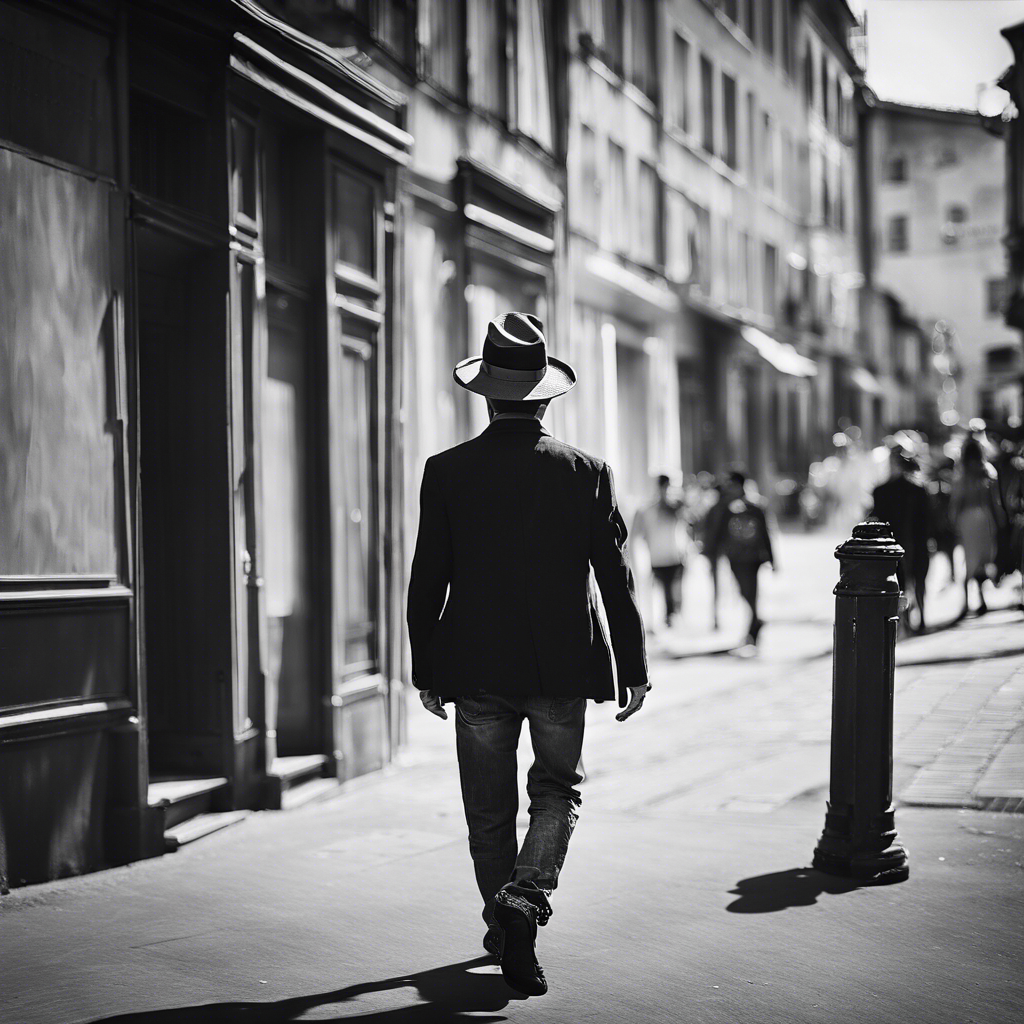

## Task 5: Background change (20 pts)
In this task, your objective is to alter the background of a given image while keeping the foreground elements or similar intact. You will utilize the Stability AI API to accomplish this.

##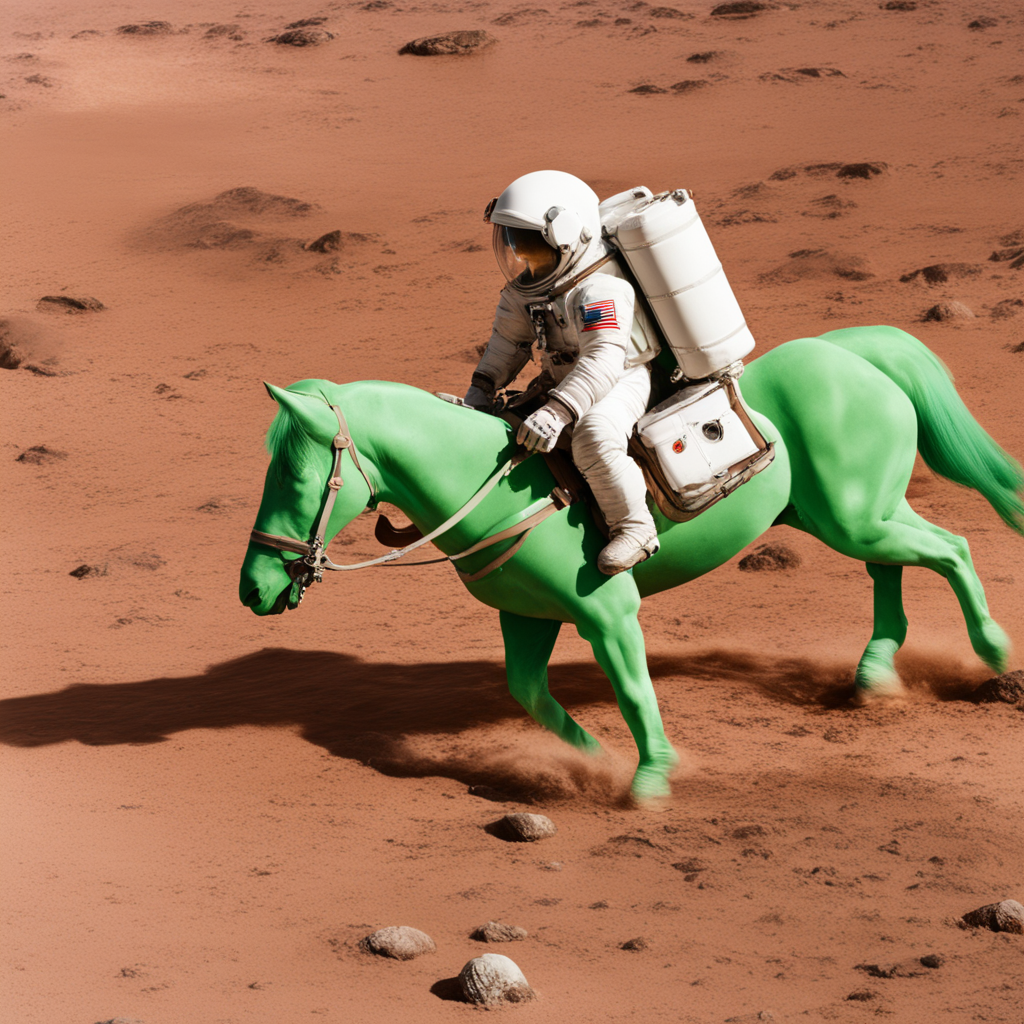

## Task 6: Hand drawn image to digital art (20 pts)

Upload a hand-drawn image and transform it into digital art using the Stability API. You could choose a sketch, a cartoon, or any other hand-drawn image. Set up the transformation parameters and display the transformed image.


## Task 7: Remove photobomber (Bonus 20 pts)
Remove the photobomber cat from the image using the Stability API. You will need to set up the prompt and display the transformed image.

Given below is the way to create a mask using segmentation model. You can use this mask to remove the cat from the image.

###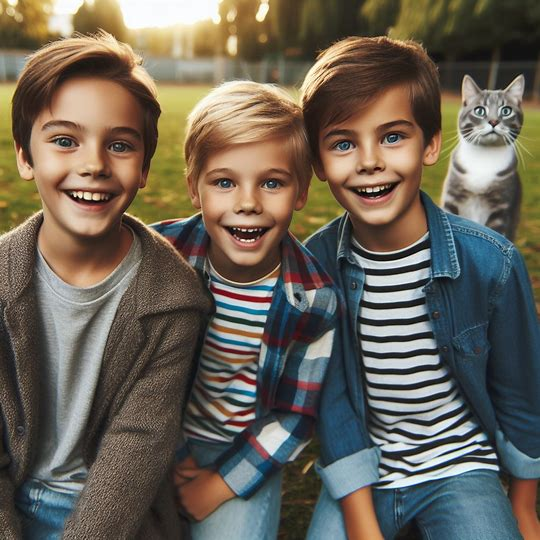

In [ ]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation
from PIL import Image
import requests
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load MaskFormer model
feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-base-coco")
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-coco")

# Load image
image = Image.open('photobomb.jpeg')

# Preprocess image for MaskFormer
inputs = feature_extractor(images=image, return_tensors="pt")

# Get segmentation prediction
outputs = model(**inputs)
result = feature_extractor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_panoptic_map = result["segmentation"]


image_np = np.array(image)
# Extract cat segmentation mask
cat_mask = np.zeros_like(predicted_panoptic_map)  # Initialize mask
cat_class_id = 4
cat_mask[predicted_panoptic_map == cat_class_id] = 1
# Convert segmentation mask to OpenCV format for processing
cat_mask_opencv = cv2.resize(cat_mask.astype(np.uint8), (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

# Create photobomber mask (adjust threshold as desired)
threshold = 0.9
thresholded_mask = np.where(cat_mask_opencv > threshold, 0, 1).astype(np.uint8)  # Invert the mask

# Convert the mask to a 3-channel image
thresholded_mask_3ch = cv2.cvtColor(thresholded_mask, cv2.COLOR_GRAY2BGR)

# Display the mask
plt.imshow(thresholded_mask_3ch * 255, cmap='gray')
# saving the mask
cv2.imwrite('mask.png', thresholded_mask_3ch * 255)


### Feathering the edges of our mask generally helps provide a better result. Alternately, you can feather the mask in a suite like Photoshop or GIMP.


In [ ]:
from torchvision.transforms import GaussianBlur
mask_i = Image.open('mask.png')


blur = GaussianBlur(11,20)
mask = blur(mask_i)
mask

### TODO: Experiment with different prompts and parameters to remove the cat from the background of the image while keeping the rest of the image same


In [ ]:
answers = stability_api.generate(
    prompt="TODO",
    init_image=img,
    mask_image=mask,
    start_schedule=1,
    seed=44332211, # If attempting to transform an image that was previously generated with our API,
                   # initial images benefit from having their own distinct seed rather than using the seed of the original image generation.
    steps=50, # Amount of inference steps performed on image generation. Defaults to 30.
    cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt.
                   # Setting this value higher increases the strength in which it tries to match your prompt.
                   # Defaults to 7.0 if not specified.
    width=1024, # Generation width, if not included defaults to 512 or 1024 depending on the engine.
    height=1024, # Generation height, if not included defaults to 512 or 1024 depending on the engine.
    sampler=generation.SAMPLER_K_DPMPP_2M # Choose which sampler we want to denoise our generation with.
                                                 # Defaults to k_lms if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_dpmpp_2s_ancestral, k_lms, k_dpmpp_2m, k_dpmpp_sde)
)

# Set up our warning to print to the console if the adult content classifier is tripped. If adult content classifier is not tripped, display generated image.
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img2 = Image.open(io.BytesIO(artifact.binary))
            display(img2)